# Neural networks training using PyTorch

In this notebook we build and train simple neural network using PyTorch. Our goal is to show the basics of torch framework and achieve simple understandings of how problemsolving with neural networks looks like.

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary

from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [39]:
device = torch.device('mps') if torch.cuda.is_available else torch.device('cpu')
device

device(type='mps')

In [40]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [41]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [42]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


Сделаем даталоадер для нашего датасета https://pytorch.org/docs/stable/data.html

In [43]:
batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [44]:
features = 784
classes = 10

Сделаем свою модельку

In [48]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 1024)
        self.fc4 = nn.Linear(1024, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model = Model(features, classes)

ИЛИ


In [49]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
)

model

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

Посмотрим как она выглядит с torch.summary

In [50]:
summary(model, (features,), batch_size=228)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


Давайте зададим лосс функцию и оптимайзер

In [51]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

Напишем тренировочный цикл и сохраним loss в переменную history

In [52]:
epochs = 3
history = []

In [53]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

        # 2. compute scores with .forward or .__call__
        logits = model(x_batch)

        # 3. compute loss
        loss = criterion(logits, y_batch)
        history.append(loss.item())

        # 4. calc gradients
        optimizer.zero_grad()
        loss.backward()

        # 5. step of gradient descent
        optimizer.step()

print(f'{i+1},\t loss: {history[-1]}')

3,	 loss: 0.040783483535051346


Посмотрим как менялся loss

In [54]:
import matplotlib.pyplot as plt

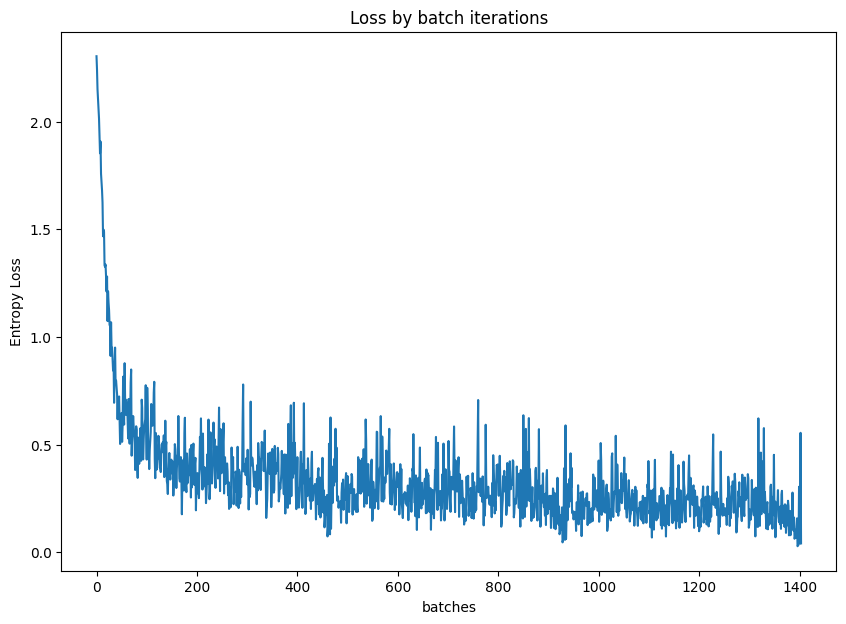

In [55]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Оценим качество модели на тесте

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # load batch of data correctly
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.939
